In [1]:
import os,sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import *
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
import random
from net_Unet_Uetpp import *
import net_Unet_Uetpp as network

#os.chdir("/content/drive/MyDrive/ISBI_pytorch/ISBI_pytorch")
batch_size = 4
H=800; W=640;
# dataloaders = {
#     'train': DataLoader(dataload(path='data/train', H=H, W=W,pow_n=8, aug=True) , batch_size=batch_size, shuffle=True, num_workers=3),
#     'val': DataLoader(dataload(path='data/val', H=H, W=W, pow_n=8, aug=False), batch_size=batch_size, shuffle=False, num_workers=3)
# }
dataloaders = {#changeBan
    'train': DataLoader(dataload(path='data/train', H=H, W=W, aug=True) , batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(dataload(path='data/val', H=H, W=W, aug=False), batch_size=batch_size, shuffle=False, num_workers=4)
}

from collections import defaultdict


# def L1_loss(pred, target):
#     loss = torch.mean(torch.abs(pred - target))
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
#     return loss
# def L2_loss(pred, target):
#     loss = torch.mean(torch.pow((pred - target), 2))
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
#     return loss
# criterion = nn.SmoothL1Loss() #changeBan
criterion = nn.L1Loss() #changeBan

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

import customCosineAnnealingWarmRestarts as custom_scheduler #changeBan
import adabound #changeBan
from tqdm import tqdm #changeBan

device_txt = "cuda:0"
device = torch.device(device_txt if torch.cuda.is_available() else "cpu")


In [2]:

if __name__ == '__main__':

    #model=torch.load('BEST.pt').to(device)
    # model=network.U_Net(img_ch=1, output_ch=10).to(device)
    #model.load_state_dict(torch.load('model/newL1_0.00015339434321504086_E_69.pth',map_location=device_txt))

    num_class = 10
    model_type = "U_net_pp"
    # model_type = "U_net"
    if model_type == "U_net":
        # model= network.U_Net(img_ch=1,output_ch=10).to(device)
        # model= network.U_Net(1,num_class).to(device)#changeBan
        model = network.U_Net(img_ch=1, output_ch=num_class).to(device)
        model.load_state_dict(torch.load('model_U_net/Network_0.008781666532158852_E_9_lr:9.992007750544879e-05.pth',map_location=device_txt)) # model loading
    elif model_type == "U_net_pp":
        model = network.U_Netpp(img_ch=1, output_ch=num_class).to(device)
        model.load_state_dict(torch.load('model_U_net_pp/Network_0.0051104378141462806_E_649_lr:1.898366210117218e-05.pth',map_location=device_txt)) # model loading
    # Observe that all parameters are being optimized
    num_epochs = 1000
    lr = 3e-5
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # optimizer = adabound.AdaBound(model.parameters(), lr=3e-4)#changBan
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 1000)
    # scheduler = custom_scheduler.CosineAnnealingWarmUpRestarts(optimizer, T_0=100, T_mult=1, eta_max=3e-3,  T_up=10, gamma=1)#changeBan
    

    print("****************************GPU : ", device)
    learning_rate = ""
    best_model_wts = copy.deepcopy(model.state_dict())
    # train_loss = 1e10
    best_loss = 1e10
    valtest = 10
    for epoch in range(num_epochs):
        print('========================' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('------------------------' * 10)
        now = time.time()

        if (epoch + 1) % valtest == 0:
            uu = ['train', 'val']
        else:
            uu = ['train']

        for phase in uu:
            # since = time.time()
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    learning_rate = param_group['lr']
                    print("LR", learning_rate)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float) # 성능 값 중첩
            epoch_samples = 0

            num_ = 0
#             progress_batch =tqdm(dataloaders[phase])#changeBan
            for inputs, labels in dataloaders[phase]:
#             for idx,(inputs, labels) in enumerate(progress_batch):#changeBan
                inputs = inputs.to(device)
                labels = labels.to(device)

                num_ = num_ + 1
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward computation
                    outputs = model(inputs) #clsout : 8by3  // cls_label : 1 by 8
                    # acloss = L2_loss(outputs, labels)
                    # loss=acloss
                    loss = criterion(outputs, labels) #changeBan
#                     metrics['Jointloss'] += loss
                    metrics[phase+'Jointloss'] += loss.item() #changeBan
                    #print("loss :" , loss, "integ loss", metrics['Jointloss'])
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    torch.cuda.empty_cache()
                # statistics
                epoch_samples += inputs.size(0)
                
            scheduler.step()
            # print_metrics(metrics, epoch_samples, phase)

            if phase == 'train':
                epoch_train_Jointloss = metrics[phase+'Jointloss'] / epoch_samples
                print(phase,"Joint loss :", epoch_train_Jointloss )
            elif phase == 'val':
                epoch_val_Jointloss = metrics[phase+'Jointloss'] / epoch_samples
                print(phase,"Joint loss :", epoch_val_Jointloss )


            # if phase == 'train' and epoch_Jointloss < train_loss:
            #     train_loss = epoch_Jointloss
            #     if 'val' not in uu:
            #         uu.append("val")
            # elif phase == 'train' and epoch_Jointloss > train_loss and (epoch + 1) % valtest != 0:
            #     if 'val' in uu:
            #         uu.remove("val")

            # deep copy the model
            folderpath = f"model_{model_type}"
            if not os.path.exists(folderpath):
                os.makedirs(folderpath)
            savepath = folderpath + '/Network_{}_E_{}_lr:{}.pth'
            if phase == 'val' and epoch_val_Jointloss < best_loss:
                print("saving best model")
                best_loss = epoch_val_Jointloss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), savepath.format(best_loss, epoch, learning_rate))

            if (epoch + 1) % 100 == 0 and epoch_val_Jointloss < best_loss:
                print("saving best model")
                best_loss = epoch_val_Jointloss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), savepath.format(best_loss, epoch, learning_rate))

        print(time.time() - now)


****************************GPU :  cuda:0
Epoch 0/999
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LR 3e-05
train Joint loss : 0.0011627725185826422
24.7485773563385
Epoch 1/999
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LR 2.9999925978027876e-05
train Joint loss : 0.0009517497406341135
23.204726457595825
Epoch 2/999
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LR 2.9999703912842056e-05
train Joint loss : 0

GT: [341. 281.] Pred: [342. 280.] Pred1: [343. 281.]
GT: [350. 470.] Pred: [353. 471.] Pred1: [353. 471.]
GT: [432. 432.] Pred: [429. 432.] Pred1: [429. 432.]
GT: [396. 208.] Pred: [395. 197.] Pred1: [395. 195.]
GT: [523. 452.] Pred: [520. 449.] Pred1: [521. 449.]
GT: [634. 428.] Pred: [629. 428.] Pred1: [630. 428.]
GT: [678. 419.] Pred: [671. 422.] Pred1: [671. 423.]
GT: [690. 407.] Pred: [688. 405.] Pred1: [688. 405.]
GT: [686. 415.] Pred: [681. 417.] Pred1: [681. 418.]
GT: [572. 230.] Pred: [571. 230.] Pred1: [574. 230.]
1----
GT: [336. 254.] Pred: [329. 252.] Pred1: [331. 253.]
GT: [312. 439.] Pred: [313. 439.] Pred1: [313. 440.]
GT: [394. 408.] Pred: [396. 405.] Pred1: [396. 405.]
GT: [390. 192.] Pred: [388. 189.] Pred1: [387. 189.]
GT: [500. 432.] Pred: [505. 435.] Pred1: [505. 434.]
GT: [614. 402.] Pred: [614. 393.] Pred1: [616. 394.]
GT: [662. 374.] Pred: [659. 375.] Pred1: [658. 374.]
GT: [674. 355.] Pred: [674. 354.] Pred1: [673. 354.]
GT: [671. 366.] Pred: [669. 367.] Pred1:

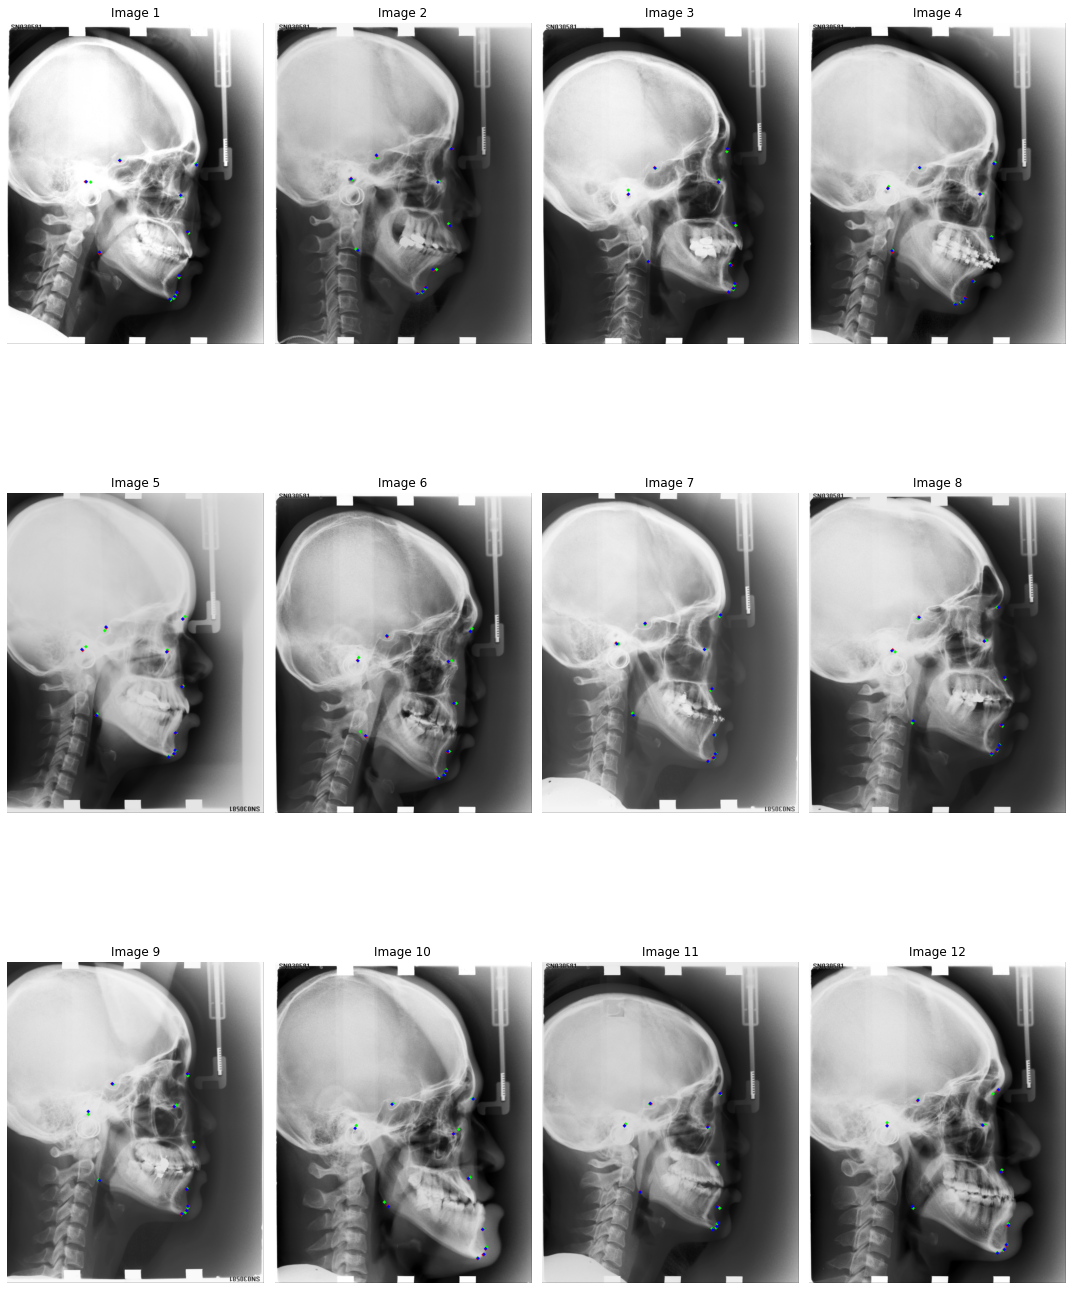

In [1]:
import os,sys
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
from collections import defaultdict
import torch.nn.functional as F
import cv2 as cv
from numpy import *
from scipy.spatial import distance

device_txt = 'cuda:0'
device = torch.device( device_txt if torch.cuda.is_available() else "cpu")

num_class = 10

### parameter modification ##########
H=800; W=640;
from net_Unet_Uetpp import *
import net_Unet_Uetpp as network

# Batch size 1
model1 = network.U_Netpp(img_ch=1, output_ch=num_class).to(device);
model1.load_state_dict(torch.load('model_U_net_pp/Network_0.0051104378141462806_E_649_lr:1.898366210117218e-05.pth',map_location=device_txt)) # model loading
model1=model1.eval()

# Batch size 4
model = network.U_Netpp(img_ch=1, output_ch=num_class).to(device);
model.load_state_dict(torch.load('model_U_net_pp/Network_0.0011458759987726809_E_69_lr:2.9585548805965122e-05.pth',map_location=device_txt)) # model loading
model=model.eval()

data = dataload(path='data/val', H=H, W=W, aug=False);

# Data loading with preprocessing
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(21)
for i in range(12):
    x = data.__getitem__(i)
    inputs = x[0]
    inputs = inputs.unsqueeze(0)
    label = x[1]
    label = label.unsqueeze(0)
    inputs = inputs.to(device)
    outputs1 = model1(inputs.data)
    outputs = model(inputs.data)
    output1 = outputs1.data
    output = outputs.data

    #########################################
    def gray_to_rgb(gray):
        h,w = gray.shape
        rgb=np.zeros((h,w,3))
        rgb[:,:,0]=gray;    rgb[:,:,1]=gray;    rgb[:,:,2]=gray;
        return rgb

    mtx = gray_to_rgb(x[0][0])
    pred_mtx =[]; gt_mtx =[]
    for k in range(0, num_class):
        C = outputs1[0][k]; C=C.cpu()
        A = outputs[0][k]; A=A.cpu()
        B = label[0][k]; B=B.cpu()
        pred1 = np.array(np.where(C > C.max() * .95)); pred1 = pred1.mean(axis=1)
        pred = np.array(np.where(A > A.max() * .95)); pred = pred.mean(axis=1)
        GT = np.array(np.where(B > B.max() * .95));   GT = GT.mean(axis=1)

        GT=np.round(GT)
        cv.circle(mtx, (int(GT[1]), int(GT[0])), 2, (0,1,0), 3); # GT
        pred1=np.round(pred1)
        cv.circle(mtx, (int(pred1[1]), int(pred1[0])), 2, (1, 0, 0), 3);  # pred1
        pred=np.round(pred)
        cv.circle(mtx, (int(pred[1]), int(pred[0])), 2, (0, 0, 1), 3);  # pred

        print("GT:" ,GT , "Pred:", pred, "Pred1:", pred1)
        pred_mtx.append(pred)
        pred_mtx.append(pred1)
        gt_mtx.append(GT)
    print(f"{i+1}----")
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(mtx)
    ax.set_title("Image " + str(i+1))
    ax.axis("off")
plt.tight_layout()
plt.show()
# plt.imshow(mtx);plt.show()
